<table>
<tr><td><img style="height: 150px;" src="images/geo_hydro1.jpg"></td>
<td bgcolor="#FFFFFF">
    <p style="font-size: xx-large; font-weight: 900; line-height: 100%">pyKOLK</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);"><b style=color:red;>Solution</b> pockets</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Georg Kaufmann</p>
    </td>
<td><img style="height: 150px;" src="images/pyKOLK.png"></td>
</tr>
</table>

----
# `pyKOLK`

pyKOLK, a program package prediction the shape of solution pockets in caves from pre-defined climate conditions.

In [1]:
import numpy as np
import scipy.interpolate
import matplotlib.pyplot as plt
import sys
import libCHEM
import libMyPlot;libMyPlot.change_fonts()

----
## Carbon-dioxide effect
In this notebook, we discuss the case, when the **surface water** seeping into the rock is equilibrated with lower
CO$_2$ levels than the **cave air**:

We use the calcium concentrations derived earlier to visualize the solution potential.

We define the calcium concentration of the drop arriving the in cave as $c_{in}$ [mol/m$^3$], and
the calcium equilibrium concentration in the cave as $c_{eq}$ [mol/m$^3$]:
$$
\begin{array}{rcl}
c_{in} &=& c_{eq}^{open/closed}(T_{rock},p_{rock}) \\
c_{eq} &=& c_{eq}^{open}(T_{cave},p_{cave})
\end{array}
$$
with 
- $T_{rock},T_{cave}$ [$^{\circ}$C] temperature in rock or cave
- $p_{rock},p_{cave}$ [ppm] CO$_2$ partial pressure in rock or cave

$c_{in}$ is controlled by the flow of the drop through the **bare rock** (no soil), 
thus can be anything from zero to equilibrium concentration, attained under open and/or closed conditions.

$c_{eq}$ depends on temperature and CO$_2$-pressure in the cave.

----
## CO$_2$ partial pressure example
CO$_2$ pressures in **rock** and **cave** different,  Temperatures equal
$$
T_{rock} = T_{cave}, p_{rock} < p_{cave}
$$

In [2]:
# fill fields for c_{eq} for two temperatures
pco2 = np.arange(400,30000,step=10)
ceq10 = libCHEM.CEQ_limestone_open(10,pco2*1e-6)
ceq20 = libCHEM.CEQ_limestone_open(20,pco2*1e-6)

# points
# points
n = np.array([1,2,3,4])
c = np.array([0.,0.68,0.68,0.92])
p = np.array([420,420,1000,1000])

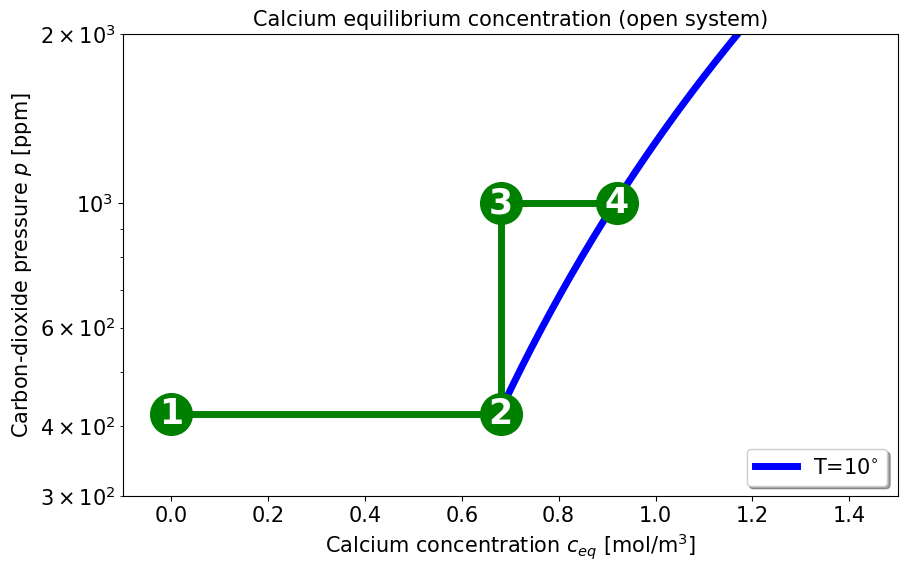

In [3]:
plt.figure(figsize=(10.0, 6.0))
plt.title('Calcium equilibrium concentration (open system)')
plt.xlim([-0.1,1.5])
plt.ylim([300,2000])
plt.xlabel('Calcium concentration $c_{eq}$ [mol/m$^3$]')
plt.ylabel('Carbon-dioxide pressure $p$ [ppm]')
plt.semilogy(ceq10,pco2,color='blue',linestyle='solid',linewidth=5,label='T=10$^{\circ}$')
#plt.semilogy(ceq20,pco2,color='red',linestyle='dashed',linewidth=3,label='T=20$^{\circ}$')
plt.plot(c,p,marker='o',markersize=30,linewidth=5,color='green')
for i in range(len(n)):
    plt.text(c[i],p[i],str(n[i]),horizontalalignment='center',verticalalignment='center',
             color='white',weight='bold',fontsize=25)
plt.legend(loc='lower right',shadow=True)
plt.savefig('figures/CHEM_CEQ_PCO2.png')

Water seeps into the ground at point **1** with a temperature of $T_{soil}=20^{\circ}$C, then 
arrives in the air-filled cave at **2**, and adjusts to the air temperature $T_{cave}=10^{\circ}$C
at point **3**. 

Carbon-dioxide remains constant, $p_{Soil}=p_{cave}=1000$ ppm.

The **cooling** results in a calcium undersaturation of around $\Delta c \sim 0.2$ mol/m$^3$.

----
### Retreat rate as a function of temperature difference

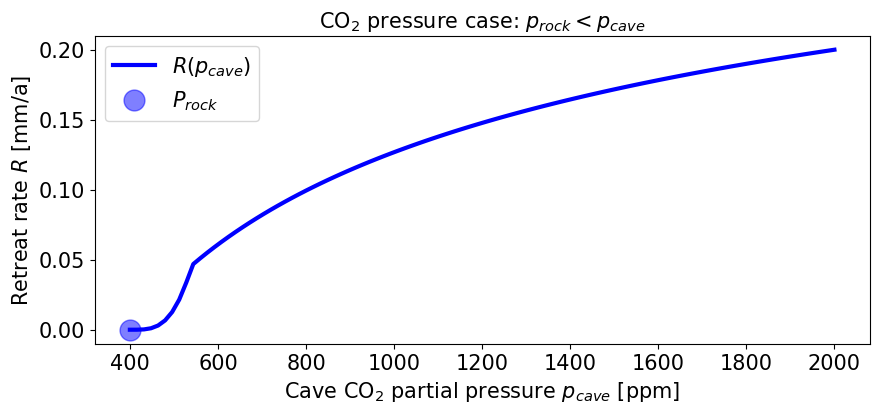

In [4]:
TempSoil = 20.
TempCave = 6.
pCO2Soil = 400e-6
pCO2Cave = 400e-6
mCaCO3   = 0.1001  # molar mass calcite [kg/mol]
rhoCaCO3 = 2700.   # density calcite [kg/m3]
year2sec = 365.25*24*60*60

# CO2 contrast
P = np.linspace(400,2000,101)
Fco2  = np.empty(len(P))
for i in range(len(P)):
    CEQsurf = libCHEM.CEQ_limestone_open(TempCave,pCO2Soil)
    CEQcave = libCHEM.CEQ_limestone_open(TempCave,P[i]*1e-6)
    Fco2[i] = libCHEM.FCaCO3(CEQsurf,CEQcave)
#print(P,Fco2)

fig,axs = plt.subplots(1,1,figsize=(10,4))
axs.set_title('CO$_2$ pressure case: $p_{rock} < p_{cave}$')
axs.set_xlabel('Cave CO$_2$ partial pressure $p_{cave}$ [ppm]')
axs.set_ylabel('Retreat rate $R$ [mm/a]')
axs.plot(P,Fco2*mCaCO3/rhoCaCO3*year2sec*1e3,lw=3,color='blue',label='$R(p_{cave})$')
axs.plot(pCO2Soil*1e6,0,lw=0,marker='o',markersize=15,color='blue',alpha=0.5,label='$P_{rock}$')
axs.set_yscale('linear')
axs.legend()

A **CO$_2$ partial pressure contrast** results in a **retreat rate** $R_0$ in the order of 10-20 cm per ka.

----
### Seasonal variation

We assume that water seeps into bare rock along the surface. 

The **temperatures** both in the rock and the cave are the same:
$T_{rock}=8^{\circ}$C and $T_{cave}=8^{\circ}$C.

The **rock carbon-dioxide concentration** fluctuates,
$$
p_{rock} = p_{rock}^{min} + \left( p_{rock}^{max} - p_{rock}^{min} \right) \frac{1}{2} \big[ 1 - \cos(2\pi t) \big]
$$
while the **cave carbon-dioxide concentration** remains:
$$
p_{cave}=1000\mbox{ ppm},
$$

We first set up time ...

In [5]:
timemin  = 0    # a
timemax  = 2    # a
timestep = 1/24 # a

nstep = int((timemax-timemin)/timestep)+1
time,dtt = np.linspace(timemin,timemax,nstep,retstep=True)

We then define climate conditions ...

In [6]:
TSoil    = 8.
TCave    = 8.
PSoilmin = 400e-6
PSoilmax = 2000e-6
PCave = 1000e-6

PSoil = 0.5 * (1. - np.cos(2*np.pi*time))
PSoil = PSoilmin + (PSoilmax-PSoilmin)*PSoil

In [7]:
CEQopen = np.zeros(len(time))
CEQcave = np.zeros(len(time))
FCave   = np.zeros(len(time))

for i in range(len(time)):
    CEQopen[i] = libCHEM.CEQ_limestone_open(TSoil,pco2=PSoil[i])
    CEQcave[i] = libCHEM.CEQ_limestone_open(TCave,pco2=PCave)
    FCave[i]   = libCHEM.FCaCO3(CEQopen[i],CEQcave[i])
    if (CEQopen[i] <= 0):
        CEQopen[i] = CEQcave[i]
    #CEQopen[i] = 0.1
    FCave[i] = libCHEM.FCaCO3(CEQopen[i],CEQcave[i])

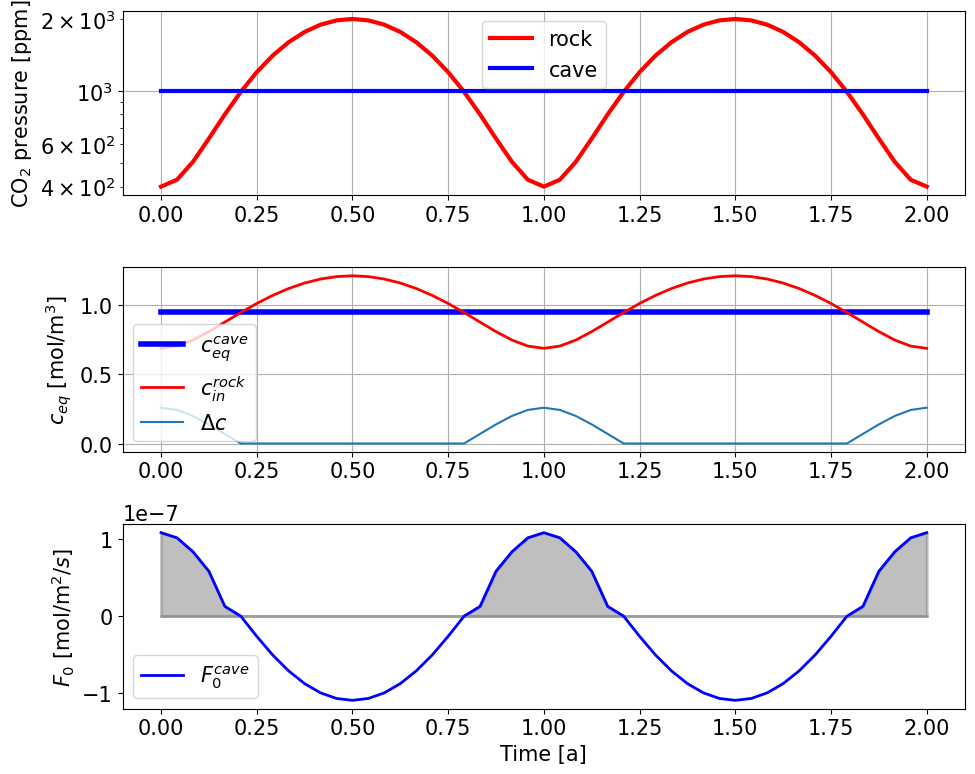

In [10]:
fig,axs = plt.subplots(3,1,figsize=(10,8))

axs[0].set_ylabel('CO$_2$ pressure [ppm]')
axs[0].set_yscale('log')
axs[0].plot(time,PSoil*1e6,lw=3,color='red',label='rock')
axs[0].plot([time.min(),time.max()],[PCave*1e6,PCave*1e6],lw=3,color='blue',label='cave')
axs[0].grid()
axs[0].legend()

axs[1].set_ylabel('$c_{eq}$ [mol/m$^3$]')
axs[1].plot(time,CEQcave,lw=4,color='blue',label='$c_{eq}^{cave}$')
axs[1].plot(time[CEQopen>0],CEQopen[CEQopen>0],lw=2,color='red',label='$c_{in}^{rock}$')
axs[1].plot(time[CEQcave-CEQopen>0],CEQcave[CEQcave-CEQopen>0]-CEQopen[CEQcave-CEQopen>0],label='$\Delta c$')
axs[1].grid()
axs[1].legend()

axs[2].set_xlabel('Time [a]')
axs[2].set_ylabel('$F_0$ [mol/m$^2/s$]')
axs[2].plot([time.min(),time.max()],[0,0],lw=2,color='gray',alpha=0.5)
axs[2].fill_between(time[FCave>=0],FCave[FCave>=0],0,lw=2,color='gray',alpha=0.5)
axs[2].plot(time,FCave,lw=2,color='blue',label='$F_0^{cave}$')
axs[2].legend()

plt.tight_layout()

We have development of ceiling pockets in the **winter months**, because CO$_2$ partial pressure is then lower outside.

----